<a href="https://colab.research.google.com/github/kurrnia/Dicoding/blob/main/Membuat_Model_Machine_Learning_dengan_Data_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series

## Putri Aulia

In [ ]:
# berfungsi untuk memanggil dataset dari gdrive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Dicoding py')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dicoding py/covid_fix3.csv')
df

,Unnamed: 0,SNo,ObservationDate,Country/Region,Confirmed,Deaths,Recovered
0,0,1,01/22/2020,Mainland China,1.0,0.0,0.0
1,1,2,01/22/2020,Mainland China,14.0,0.0,0.0
2,2,3,01/22/2020,Mainland China,6.0,0.0,0.0
3,3,4,01/22/2020,Mainland China,1.0,0.0,0.0
4,4,5,01/22/2020,Mainland China,0.0,0.0,0.0
...,...,...,...,...,...,...,...
306424,306424,306425,05/29/2021,Ukraine,102641.0,2335.0,95289.0
306425,306425,306426,05/29/2021,Netherlands,29147.0,245.0,0.0
306426,306426,306427,05/29/2021,Mainland China,1364.0,1.0,1324.0
306427,306427,306428,05/29/2021,Ukraine,87550.0,1738.0,83790.0


In [ ]:
df = df.drop(['Unnamed: 0'], axis=1)
df

,SNo,ObservationDate,Country/Region,Confirmed,Deaths,Recovered
0,1,01/22/2020,Mainland China,1.0,0.0,0.0
1,2,01/22/2020,Mainland China,14.0,0.0,0.0
2,3,01/22/2020,Mainland China,6.0,0.0,0.0
3,4,01/22/2020,Mainland China,1.0,0.0,0.0
4,5,01/22/2020,Mainland China,0.0,0.0,0.0
...,...,...,...,...,...,...
306424,306425,05/29/2021,Ukraine,102641.0,2335.0,95289.0
306425,306426,05/29/2021,Netherlands,29147.0,245.0,0.0
306426,306427,05/29/2021,Mainland China,1364.0,1.0,1324.0
306427,306428,05/29/2021,Ukraine,87550.0,1738.0,83790.0


In [ ]:
# karena banyaknya data maka saya melakukan pembatasan terhadap data tersebut
df=df[['SNo', 'ObservationDate', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
df_sub=df[df.SNo <=1500]
df_sub.head()

,SNo,ObservationDate,Country/Region,Confirmed,Deaths,Recovered
0,1,01/22/2020,Mainland China,1.0,0.0,0.0
1,2,01/22/2020,Mainland China,14.0,0.0,0.0
2,3,01/22/2020,Mainland China,6.0,0.0,0.0
3,4,01/22/2020,Mainland China,1.0,0.0,0.0
4,5,01/22/2020,Mainland China,0.0,0.0,0.0


In [ ]:
df_sub.info

<bound method DataFrame.info of        SNo ObservationDate  Country/Region  Confirmed  Deaths  Recovered
0        1      01/22/2020  Mainland China        1.0     0.0        0.0
1        2      01/22/2020  Mainland China       14.0     0.0        0.0
2        3      01/22/2020  Mainland China        6.0     0.0        0.0
3        4      01/22/2020  Mainland China        1.0     0.0        0.0
4        5      01/22/2020  Mainland China        0.0     0.0        0.0
...    ...             ...             ...        ...     ...        ...
1495  1496      02/14/2020     South Korea       28.0     0.0        7.0
1496  1497      02/14/2020        Malaysia       19.0     0.0        3.0
1497  1498      02/14/2020  Mainland China       18.0     0.0       11.0
1498  1499      02/14/2020          Taiwan       18.0     0.0        2.0
1499  1500      02/14/2020         Germany       16.0     0.0        1.0

[1500 rows x 6 columns]>

In [ ]:
df_sub.isnull().sum()

SNo                0
ObservationDate    0
Country/Region     0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

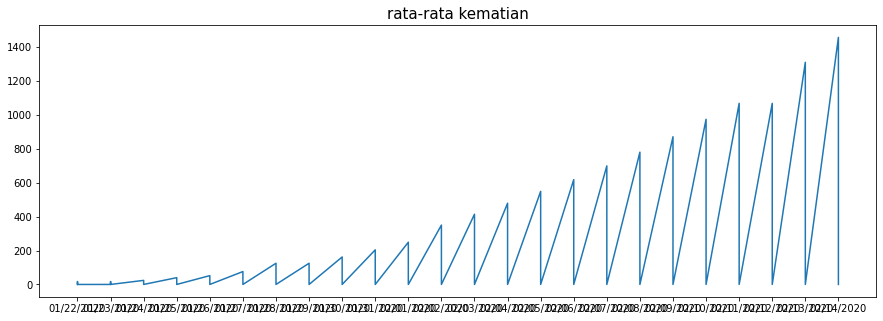

In [ ]:
dates = df_sub['ObservationDate'].values
temp  = df_sub['Deaths'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('rata-rata kematian',
          fontsize=15);

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)

Epoch 1/50
15/15 [==============================] - 8s 192ms/step - loss: 8.3457 - mae: 8.4457
Epoch 2/50
15/15 [==============================] - 3s 156ms/step - loss: 8.3449 - mae: 8.4477
Epoch 3/50
15/15 [==============================] - 2s 117ms/step - loss: 8.3440 - mae: 8.4506
Epoch 4/50
15/15 [==============================] - 2s 113ms/step - loss: 8.3431 - mae: 8.4535
Epoch 5/50
15/15 [==============================] - 2s 122ms/step - loss: 8.3422 - mae: 8.4565
Epoch 6/50
15/15 [==============================] - 3s 194ms/step - loss: 8.3412 - mae: 8.4595
Epoch 7/50
15/15 [==============================] - 2s 126ms/step - loss: 8.3403 - mae: 8.4626
Epoch 8/50
15/15 [==============================] - 2s 112ms/step - loss: 8.3394 - mae: 8.4656
Epoch 9/50
15/15 [==============================] - 2s 114ms/step - loss: 8.3385 - mae: 8.4685
Epoch 10/50
15/15 [==============================] - 2s 116ms/step - loss: 8.3376 - mae: 8.4716
Epoch 11/50
15/15 [==============================